# Simple TOPFARM Example

In [27]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [28]:
from py_wake.examples.data.dtu10mw import DTU10MW
from py_wake.examples.hornsrev1_example import Hornsrev1Site
from py_wake import Nygaard_2022

from topfarm import TopFarmProblem, TopFarmGroup
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent
#from topfarm.easy_drivers import EasyRandomSearchDriver
#from topfarm.drivers.random_search_driver import RandomizeTurbinePosition_Circle
from topfarm.plotting import XYPlotComp
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm.cost_models.economic_models.dtu_wind_cm_main import economic_evaluation
from topfarm.utils import plot_list_recorder

from optiwindnet.api import WindFarmNetwork, HGSRouter #, MILPRouter
from optiwindnet.augmentation import poisson_disc_filler

# gradient
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.cost_models.cost_model_wrappers import CostModelComponent


In [29]:
# Display figures as SVG in Jupyter notebooks
%config InlineBackend.figure_formats = ['svg']

## Wind farm design parameters

Define turbine type and count:

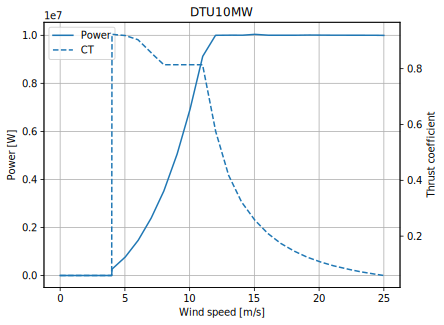

In [30]:
wind_turbines = DTU10MW()
n_wt = 20
wind_turbines.plot_power_ct();

Define the wind resource:

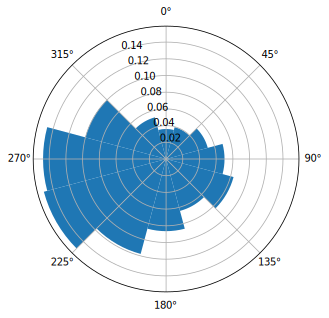

In [31]:
site = Hornsrev1Site()
site.plot_wd_distribution();

Define the area:

In [32]:
d_west_east = 4000  # [m] width
d_south_north = 2000  # [m] height
min_wt_spacing = 3.5*wind_turbines.diameter()  # [m] inter-turbine minimum distance
boundary = np.array([
    (0, 0),
    (d_west_east, 0),
    (d_west_east, d_south_north),
    (0, d_south_north)
])

Define the substation position:

In [33]:
x_ss, y_ss = (d_west_east/5, d_south_north/2)

Define the maximum step for the random search:

In [34]:
max_step = 100  # [m]

## Initial positions

In [35]:
# Generate initial random layout
x_init, y_init = poisson_disc_filler(
    n_wt,
    min_dist=min_wt_spacing,
    BorderC=boundary,
    seed=42,
    rounds=10,
).T

## Electrical Network

In [36]:
wfn = WindFarmNetwork(
    turbinesC=np.column_stack((x_init, y_init)),
    substationsC=np.array([(x_ss, y_ss)]),
    #borderC=boundary,
    cables=[(2, 2000), (5, 2200)],
    buffer_dist=max_step,
    router=HGSRouter(time_limit=0.1),
    # router=MILPRouter(
    #     solver_name='gurobi',
    #     # solver_name='ortools',
    #     time_limit=0.2,
    #     mip_gap=0.005
    # ),
)

In [37]:
wfn.plot_original_vs_buffered();

No buffering is perfomred


In [38]:
# def cost_network(x, y, **kwargs):
def calc_network_cost(x, y):
    wfn.optimize(
        turbinesC=np.column_stack((x, y)),
    )
    # return wfn.cost()
    return wfn.cost(), {'terse_links': wfn.terse_links()}
    # return wfn.cost(), {'cabling_length': wfn.length(),
    #                     'terse_links': wfn.terse_links()}


def calc_network_cost_partials(x, y):
    partials = wfn.gradient(gradient_type='cost')
    return tuple(*partials.T)

Generate initial network

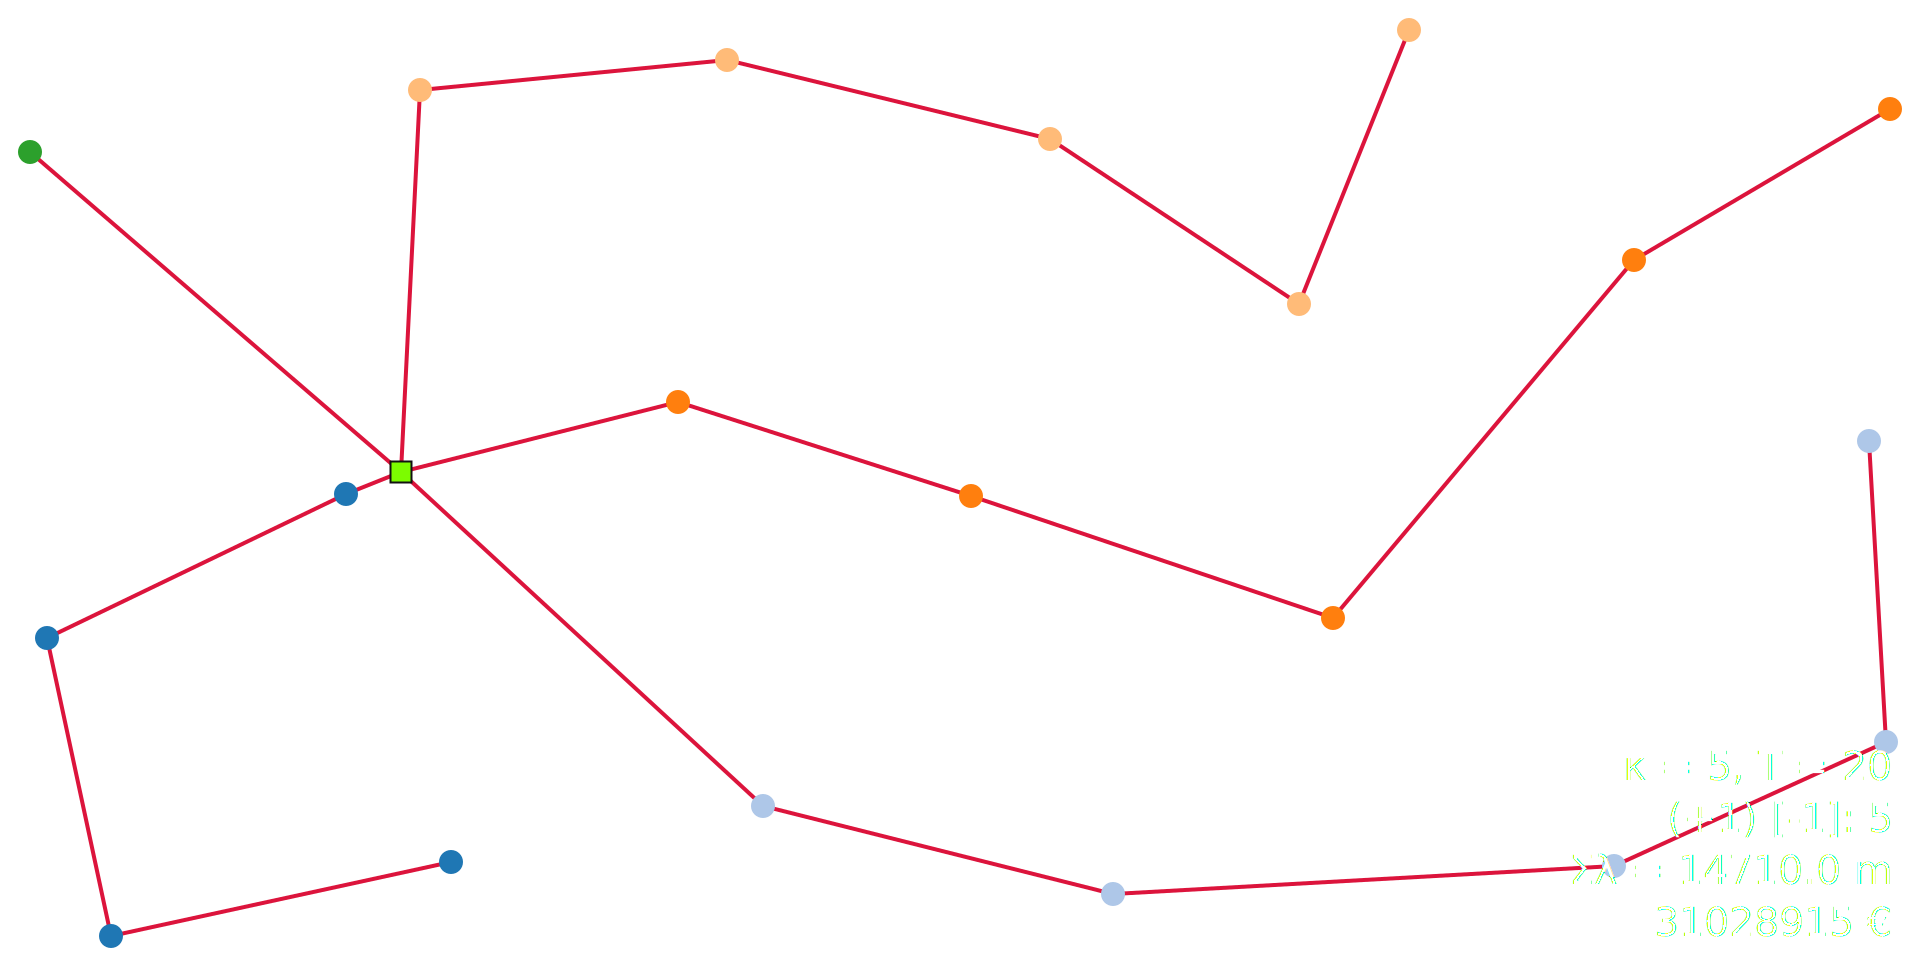

In [39]:
wfn.optimize()
wfn

## Build models

In [40]:
fixed_economic_parameters = dict(
    rated_rpm_array=np.full((n_wt,), 12.0),
    D_rotor_array=np.full((n_wt,), wind_turbines.diameter()),
    Power_rated_array=np.full((n_wt,), wind_turbines.power(20.0)*1e-6),
    hub_height_array=np.full((n_wt,), wind_turbines.hub_height()),
    water_depth_array=np.full((n_wt,), 33.0),
)

In [41]:
eco_eval = economic_evaluation(
    distance_from_shore=30,  # [km]
    energy_price=0.06,        # [€/kWh] revenue
    project_duration=25,     # [years]
)

In [42]:
# Internal Rate of Return
def calc_irr(AEP, cabling_cost, **kwargs):
    return eco_eval.calculate_irr(
        **fixed_economic_parameters,
        aep_array=np.full((n_wt,), AEP/n_wt*10**6),
        cabling_cost=cabling_cost,
    )

In [43]:
# number of wind directions to consider
n_wd = 12

aep_comp = PyWakeAEPCostModelComponent(
    windFarmModel=Nygaard_2022(
        site=site,
        windTurbines=wind_turbines,
    ),
    n_wt=n_wt,
    wd=np.linspace(0.0, 360.0, n_wd, endpoint=False),
    objective=False,
)

In [44]:
# Network
network_cost_comp = CostModelComponent(
    input_keys=[
        ('x', x_init),
        ('y', y_init),
    ],
    n_wt=n_wt,
    cost_function=calc_network_cost,
    objective=False,
    output_keys=[('cabling_cost', 0.0)],
    additional_output=[
        ('terse_links', np.zeros((n_wt,), dtype=int)),
    ],
)

In [45]:
# Economy
npv_comp = CostModelComponent(
    input_keys=[
        ('AEP', 0),
        ('cabling_cost', wfn.cost())
    ],
    n_wt=n_wt,
    # cost_function=calc_npv,
    cost_function=calc_irr,
    objective=True,
    maximize=True,
    # output_keys=[('NPV', 0)],
    output_keys=[('IRR', 0)],
)

## Build Topfarm problem

In [46]:
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from optiwindnet.api import WindFarmNetwork, EWRouter, MILPRouter, ModelOptions
import numpy as np

class WindFarmNetworkComponent(CostModelComponent):
    """
    A wrapper for the WindFarmNetwork component that integrates with the CostModelWrapper.
    This class allows for the use of different routing algorithms and model options.
    """

    def __init__(self, x_init, y_init, n_wt, boundary, **kwargs):
        x_ss_init = x_init.mean()
        y_ss_init = y_init.mean()
        turbines_pos=  np.column_stack((x_init, y_init))
        substations_pos =  np.column_stack((x_ss_init, y_ss_init))

        cables = np.array([(3, 100),(5, 150), (10, 250)])  #

        borderC =  boundary

        self.router = HGSRouter(time_limit=0.1)
        self.wfn = WindFarmNetwork(turbinesC=turbines_pos, substationsC=substations_pos, cables=cables, router=self.router) #, borderC=borderC, buffer_dist=0.1)


        def compute(x, y, x_substation, y_substation):
            self.wfn.optimize(turbinesC= np.column_stack((x, y)), substationsC= np.column_stack((float(x_substation[0]), float(y_substation[0]))))
            return self.wfn.cost(), {'cabling_length': self.wfn.length(), 'terse_links': self.wfn.terse_links()}
        def compute_partials(x, y , x_substation, y_substation):
            grad_wt, grad_ss = self.wfn.gradient(turbinesC= np.column_stack((x, y)), substationsC= np.column_stack((float(x_substation[0]), float(y_substation[0]))))
            return [grad_wt, grad_ss]

        super().__init__(input_keys=[('x', x_init),('y', y_init), ('x_substation', x_ss_init), ('y_substation', y_ss_init)],
                                     n_wt=n_wt,
                                     cost_function=compute,
                                     cost_gradient_function=compute_partials,
                                     output_keys=[('cabling_cost', 0)],
                                     additional_output = [
                                                ('cabling_length', 0.0),
                                                ('terse_links', np.zeros((n_wt,)))
                                                ], **kwargs)

In [47]:
network_cost_comp2 = WindFarmNetworkComponent(
    x_init=x_init,
    y_init=y_init,
    n_wt=n_wt,
    boundary=boundary
)

In [48]:
cost_comp = TopFarmGroup([
    aep_comp,
    network_cost_comp,
    npv_comp,
])

In [49]:
tf_problem = TopFarmProblem(
    design_vars=dict(
        x=x_init,
        y=y_init,
    ),
    cost_comp=cost_comp,
    constraints=[
        XYBoundaryConstraint(boundary, 'polygon'),
        SpacingConstraint(min_wt_spacing)
    ],
    driver=EasyScipyOptimizeDriver(tol=1e-6, disp=True),
    #     EasyRandomSearchDriver(
    #     RandomizeTurbinePosition_Circle(max_step=max_step),
    #     max_iter=2000,
    #     max_time=600,
    # ),
    plot_comp=XYPlotComp(),
)

INFO: checking out_of_order...
INFO:     out_of_order check complete (0.000450 sec).


INFO: checking system...
INFO:     system check complete (0.000057 sec).
INFO: checking solvers...
INFO:     solvers check complete (0.000271 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check complete (0.000061 sec).
INFO: checking missing_recorders...
INFO:     missing_recorders check complete (0.000006 sec).
INFO: checking unserializable_options...
INFO:     unserializable_options check complete (0.000295 sec).
INFO: checking comp_has_no_outputs...
INFO:     comp_has_no_outputs check complete (0.000085 sec).
INFO: checking auto_ivc_warnings...
INFO:     auto_ivc_warnings check complete (0.000007 sec).


INFO: checking out_of_order...
INFO:     out_of_order check complete (0.000768 sec).
INFO: checking system...
INFO:     system check complete (0.000061 sec).
INFO: checking solvers...
INFO:     solvers check complete (0.000429 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check complete (0.000144 sec).
INFO: checking missing_recorders...
INFO:     missing_recorders check complete (0.000013 sec).
INFO: checking unserializable_options...
INFO:     unserializable_options check complete (0.000398 sec).
INFO: checking comp_has_no_outputs...
INFO:     comp_has_no_outputs check complete (0.000111 sec).
INFO: checking auto_ivc_warnings...
INFO:     auto_ivc_warnings check complete (0.000014 sec).


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


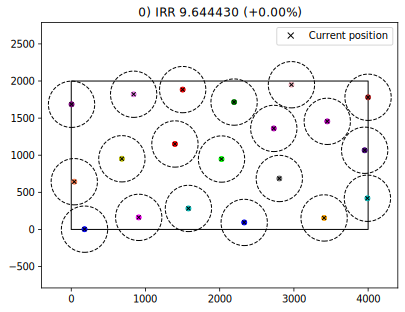

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.1407705136487
            Iterations: 93
            Function evaluations: 125
            Gradient evaluations: 93
Optimization Complete
-----------------------------------
Optimized in	520.068s
 

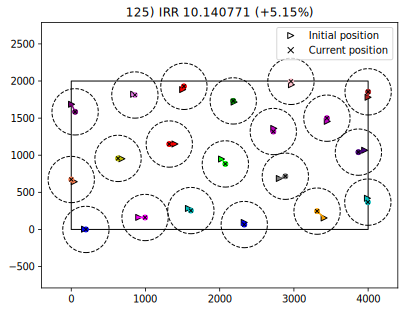

         108746046 function calls (105647836 primitive calls) in 542.371 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     3846  382.815    0.100  383.483    0.100 hybgensea.py:319(_solve_cvrp_dist_mtx)
     7692   31.810    0.004   33.960    0.004 mesh.py:208(_planar_from_cdt_triangles)
1136874/777894    5.247    0.000   20.209    0.000 tracer.py:35(f_wrapped)
    42306    3.563    0.000    6.021    0.000 graph.py:975(add_edges_from)
  4509406    3.384    0.000    3.384    0.000 {method 'item' of 'numpy.generic' objects}
    11538    3.144    0.000    3.144    0.000 {built-in method nt.open}
   758043    2.992    0.000    4.992    0.000 tracer.py:58(f_wrapped)
     7692    2.973    0.000   11.928    0.002 mesh.py:257(_P_from_halfedge_pack)
  1015344    2.786    0.000    6.638    0.000 planarity.py:1008(add_half_edge)
     7692    2.256    0.000    2.256    0.000 {method 'close' of '_io.TextIOWrapper' objects}
  1015344 

In [50]:
%prun cost, state, recorder = tf_problem.optimize(disp=True)

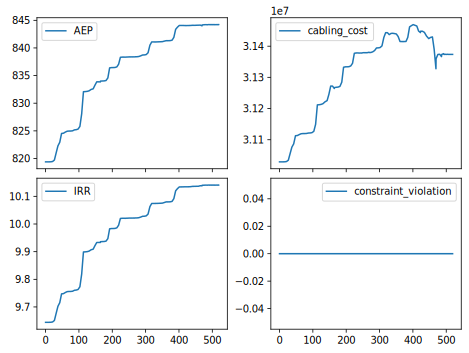

In [51]:
records_to_plot = ['AEP', 'cabling_cost', 'IRR', 'constraint_violation']
time = recorder['timestamp'] - recorder['timestamp'][0]
fig, axs = plt.subplots(math.ceil(len(records_to_plot)/2), 2, sharex=True, layout='constrained')
for ax, record_key in zip(axs.ravel(), records_to_plot):
    ax.plot(time, recorder[record_key], label=record_key)
    ax.legend()

<Axes: >

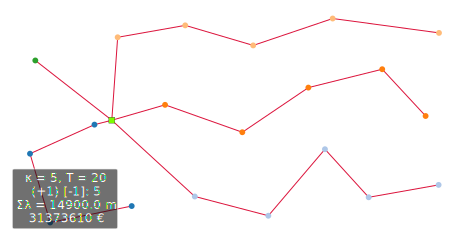

In [52]:
wfn.plot()